In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# 데이터셋 인스턴스 생성

data = pd.read_csv('C:/Users/ghom9/Downloads/diabetes.csv')  # CSV 파일 경로
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
print(data.isna().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [5]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [7]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [9]:
# tensors로 변환
# dtype은 값의 형태에 따라서 설정
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [10]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

# 모델 정의

In [59]:
class diabetesDense(nn.Module):
    def __init__(self):
        super(diabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = diabetesDense()

# 손실 함수 및 최적화 기법 정의

In [60]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습

In [61]:
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train() # 모델을 학습 모드로 전환
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        labels = labels.view(-1, 1).float()  # shape: (batch_size, 1), type: float
        optimizer.zero_grad()  # 기존에 누적된 gradient 초기화

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))
    
    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            labels = labels.view(-1, 1).float()
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)  # 확률
            predicted = (probs >= 0.5).float()
            labels = labels.float()  # 정수일 수 있으므로 float으로 변환
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")


Epoch 1/30, Loss: 0.6955, Accuracy: 65.58%
Epoch 2/30, Loss: 0.6634, Accuracy: 76.62%
Epoch 3/30, Loss: 0.6261, Accuracy: 77.27%
Epoch 4/30, Loss: 0.5871, Accuracy: 76.62%
Epoch 5/30, Loss: 0.5451, Accuracy: 77.27%
Epoch 6/30, Loss: 0.5076, Accuracy: 76.62%
Epoch 7/30, Loss: 0.5021, Accuracy: 79.87%
Epoch 8/30, Loss: 0.4951, Accuracy: 79.87%
Epoch 9/30, Loss: 0.4800, Accuracy: 80.52%
Epoch 10/30, Loss: 0.4817, Accuracy: 81.82%
Epoch 11/30, Loss: 0.4753, Accuracy: 80.52%
Epoch 12/30, Loss: 0.4671, Accuracy: 81.17%
Epoch 13/30, Loss: 0.4565, Accuracy: 81.82%
Epoch 14/30, Loss: 0.4505, Accuracy: 80.52%
Epoch 15/30, Loss: 0.4643, Accuracy: 82.47%
Epoch 16/30, Loss: 0.4427, Accuracy: 79.87%
Epoch 17/30, Loss: 0.4596, Accuracy: 79.87%
Epoch 18/30, Loss: 0.4504, Accuracy: 80.52%
Epoch 19/30, Loss: 0.4442, Accuracy: 81.17%
Epoch 20/30, Loss: 0.4523, Accuracy: 80.52%
Epoch 21/30, Loss: 0.4423, Accuracy: 80.52%
Epoch 22/30, Loss: 0.4459, Accuracy: 79.22%
Epoch 23/30, Loss: 0.4612, Accuracy: 79.2

In [64]:
summary(model, input_size=(8,))  # ← feature가 ~개일 경우

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             288
            Linear-2                   [-1, 16]             528
            Linear-3                    [-1, 1]              17
Total params: 833
Trainable params: 833
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# 모델 평가

In [62]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        predicted = (probs >= 0.5).int().view(-1)  # 예측 결과 0 또는 1로 만들기

        all_labels.extend(labels.int().view(-1).cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[93 14]
 [16 31]]
F1 Score: 0.80
Precision: 0.80
Recall: 0.81
Specificity: 0.76


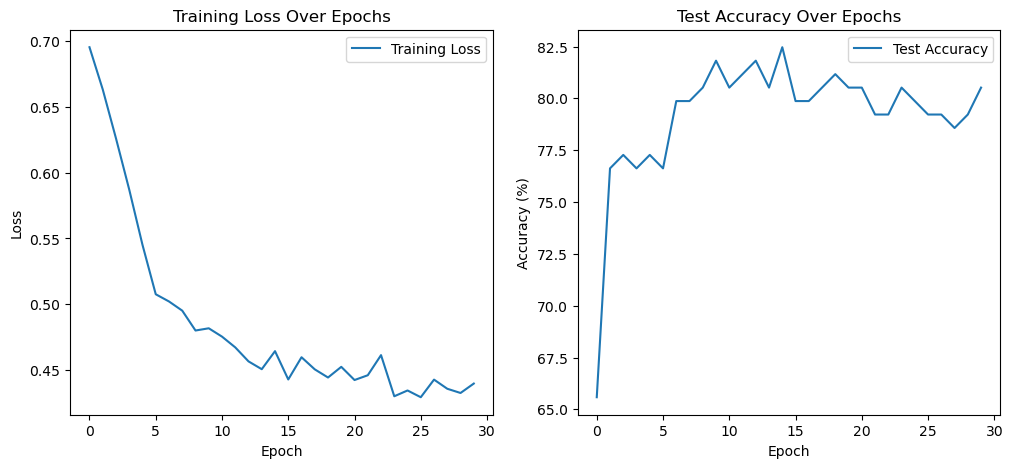

In [63]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()